In [1]:
import pandas as pd
import numpy as np

# Data pre-processing
import nltk
from nltk.stem import WordNetLemmatizer

# List of stop words used for data pre-processing
from stop_words_list import stop_words_list
from nltk.corpus import stopwords

# Sentiment Analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Topics modelling
from gsdmm.gsdmm.mgp import MovieGroupProcess

In [2]:
# List of the creators that can be used: "MKBHD", "Jonathan Morrison", "Unbox Therapy", "Chris Stuckman", "Jeremy Jahns", "Channel Awesome", "James Charles", "NikkieTutorials", "sophdoeslife"

creator = "sophdoeslife"
output_df = pd.read_excel(f"./comments_spreadsheets/extracted_comments_{creator}.xlsx")

In [3]:
duplicates = output_df[output_df.duplicated(("Comments"))]
print ("Count of duplicate comments in dataframe"
, duplicates.shape[0])

print ("Count of unique comments in dataframe"
, output_df.shape[0] - duplicates.shape[0])

# Remove duplicated comments from dataset
unique_df = output_df.drop_duplicates(subset=["Comments"], keep='first')
df = unique_df.reset_index()

# Removes line return "\n"
df = df.replace(r'\n',' ', regex=True)

display(df)

Count of duplicate comments in dataframe 4
Count of unique comments in dataframe 410


,index,Video ID,Comment ID,Comments
0,0,c0nsB-bStks,UgxjrHRhAe3afInc3nB4AaABAg,"I would like to add, the eye makeup still look..."
1,1,c0nsB-bStks,UgxIjuFycwS3XLKYI8x4AaABAg,"It's may seem like a little thing, but I reall..."
2,2,c0nsB-bStks,UgzVBndPTTlIMSSRG994AaABAg,"Honestly, as a sci-fi and fantasy nerd, I love..."
3,3,c0nsB-bStks,UgwOWA6VnsLN6mMaeaN4AaABAg,What an amazing compliment to you that you rec...
4,4,c0nsB-bStks,UgxHfRFjONAr_Kx0rRt4AaABAg,Is everyone just creating makeup now? Don't ge...
...,...,...,...,...
405,409,c0nsB-bStks,UgwE7rCA1yhaCPz6_xJ4AaABAg,Early
406,410,c0nsB-bStks,Ugx2qmDyUelip8WOqfZ4AaABAg,Omg 13 min agoo
407,411,c0nsB-bStks,UgwwUH9XcPPQE2kMSX94AaABAg,Hi
408,412,c0nsB-bStks,Ugx0aXNqQqth1bgPQmZ4AaABAg,18歳以上の場合 ⤵⤵(◠$◕)♪❤ ---------------------------...


In [4]:
# SENTIMENT ANALYSIS

sentimentAnalyser = SentimentIntensityAnalyzer()
sentimentScoreList = []
sentimentLabelList = []

for i in df["Comments"].values.tolist():
    sentimentScore = sentimentAnalyser.polarity_scores(i)

    if sentimentScore['compound'] >= 0.05:
        sentimentScoreList.append(sentimentScore['compound'])
        sentimentLabelList.append('Positive')
    elif sentimentScore['compound'] > -0.05 and sentimentScore['compound'] < 0.05:
        sentimentScoreList.append(sentimentScore['compound'])
        sentimentLabelList.append('Neutral')
    elif sentimentScore['compound'] <= -0.05:
        sentimentScoreList.append(sentimentScore['compound'])
        sentimentLabelList.append('Negative')

df["Sentiment"] = sentimentLabelList
df["Sentiment Score"] = sentimentScoreList

display(df.head(10))

,index,Video ID,Comment ID,Comments,Sentiment,Sentiment Score
0,0,c0nsB-bStks,UgxjrHRhAe3afInc3nB4AaABAg,"I would like to add, the eye makeup still look...",Positive,0.8683
1,1,c0nsB-bStks,UgxIjuFycwS3XLKYI8x4AaABAg,"It's may seem like a little thing, but I reall...",Positive,0.9624
2,2,c0nsB-bStks,UgzVBndPTTlIMSSRG994AaABAg,"Honestly, as a sci-fi and fantasy nerd, I love...",Positive,0.9319
3,3,c0nsB-bStks,UgwOWA6VnsLN6mMaeaN4AaABAg,What an amazing compliment to you that you rec...,Positive,0.9446
4,4,c0nsB-bStks,UgxHfRFjONAr_Kx0rRt4AaABAg,Is everyone just creating makeup now? Don't ge...,Positive,0.9563
5,5,c0nsB-bStks,Ugyk8Gma2bJhEWjgueJ4AaABAg,So happy that you received the package on PR!🥰...,Positive,0.9503
6,6,c0nsB-bStks,Ugz0_Hj0d7ih-xt0_SF4AaABAg,Love the hair! I'm not interested in R.E.M. b...,Positive,0.9404
7,7,c0nsB-bStks,UgylGcBaQ4bk-DFJACJ4AaABAg,Am I the only person who's obsessed with the '...,Positive,0.1280
8,8,c0nsB-bStks,UgzYUURSbLEbgG9whsN4AaABAg,I'm so excited for this. I'm glad the uploads ...,Positive,0.9484
9,9,c0nsB-bStks,UgwZbFjXB5xe3gUz6uV4AaABAg,"I like the lashes they are pretty, and definit...",Positive,0.8126


In [5]:
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in text]

# Convert case text as lowercase, remove punctuation, remove extra whitespace in string and on both sides of string
# Lowercase all the letters
df['lower'] = df['Comments'].str.lower()

# Remove punctuations
df['punctuation_removed'] = df['lower'].str.replace("'", '', regex=True).str.replace('[^\w\s]', ' ', regex=True)

# Remove numbers
df['numbers_removed'] = df['punctuation_removed'].str.replace(" \d+", " ", regex=True)

# Remove extra whitespace
df['extra_spaces_removed'] = df['numbers_removed'].str.replace(' +', ' ', regex=True).str.strip()

# Tokenise
df['tokenised'] = df.apply(lambda row: nltk.word_tokenize(row['extra_spaces_removed']), axis=1)

# Stop words removal
# initiate stopwords from nltk
stop_words = stopwords.words('english')
# add additional missing terms
stop_words.extend(stop_words_list)
# remove stopwords
df['removed_stopwords'] = df['tokenised'].apply(lambda x: [item for item in x if item not in stop_words])

docs = []

for token in df.removed_stopwords:
    docs.append(token)

display(df.head(10))

,index,Video ID,Comment ID,Comments,Sentiment,Sentiment Score,lower,punctuation_removed,numbers_removed,extra_spaces_removed,tokenised,removed_stopwords
0,0,c0nsB-bStks,UgxjrHRhAe3afInc3nB4AaABAg,"I would like to add, the eye makeup still look...",Positive,0.8683,"i would like to add, the eye makeup still look...",i would like to add the eye makeup still look...,i would like to add the eye makeup still look...,i would like to add the eye makeup still looks...,"[i, would, like, to, add, the, eye, makeup, st...","[add, eye, makeup, perfect, hours, including, ..."
1,1,c0nsB-bStks,UgxIjuFycwS3XLKYI8x4AaABAg,"It's may seem like a little thing, but I reall...",Positive,0.9624,"it's may seem like a little thing, but i reall...",its may seem like a little thing but i really...,its may seem like a little thing but i really...,its may seem like a little thing but i really ...,"[its, may, seem, like, a, little, thing, but, ...","[thing, appreciate, transition, shade, depends..."
2,2,c0nsB-bStks,UgzVBndPTTlIMSSRG994AaABAg,"Honestly, as a sci-fi and fantasy nerd, I love...",Positive,0.9319,"honestly, as a sci-fi and fantasy nerd, i love...",honestly as a sci fi and fantasy nerd i love...,honestly as a sci fi and fantasy nerd i love...,honestly as a sci fi and fantasy nerd i love t...,"[honestly, as, a, sci, fi, and, fantasy, nerd,...","[honestly, sci, fi, fantasy, nerd, theme, pack..."
3,3,c0nsB-bStks,UgwOWA6VnsLN6mMaeaN4AaABAg,What an amazing compliment to you that you rec...,Positive,0.9446,what an amazing compliment to you that you rec...,what an amazing compliment to you that you rec...,what an amazing compliment to you that you rec...,what an amazing compliment to you that you rec...,"[what, an, amazing, compliment, to, you, that,...","[amazing, compliment, received, pr, ag, deserv..."
4,4,c0nsB-bStks,UgxHfRFjONAr_Kx0rRt4AaABAg,Is everyone just creating makeup now? Don't ge...,Positive,0.9563,is everyone just creating makeup now? don't ge...,is everyone just creating makeup now dont get...,is everyone just creating makeup now dont get...,is everyone just creating makeup now dont get ...,"[is, everyone, just, creating, makeup, now, do...","[creating, makeup, wrong, ari, makeup, stunnin..."
5,5,c0nsB-bStks,Ugyk8Gma2bJhEWjgueJ4AaABAg,So happy that you received the package on PR!🥰...,Positive,0.9503,so happy that you received the package on pr!🥰...,so happy that you received the package on pr ...,so happy that you received the package on pr ...,so happy that you received the package on pr i...,"[so, happy, that, you, received, the, package,...","[happy, received, package, pr, personally, buy..."
6,6,c0nsB-bStks,Ugz0_Hj0d7ih-xt0_SF4AaABAg,Love the hair! I'm not interested in R.E.M. b...,Positive,0.9404,love the hair! i'm not interested in r.e.m. b...,love the hair im not interested in r e m bu...,love the hair im not interested in r e m bu...,love the hair im not interested in r e m but i...,"[love, the, hair, im, not, interested, in, r, ...","[hair, interested, enjoyed, watching, products]"
7,7,c0nsB-bStks,UgylGcBaQ4bk-DFJACJ4AaABAg,Am I the only person who's obsessed with the '...,Positive,0.1280,am i the only person who's obsessed with the '...,am i the only person whos obsessed with the ch...,am i the only person whos obsessed with the ch...,am i the only person whos obsessed with the ch...,"[am, i, the, only, person, whos, obsessed, wit...","[person, obsessed, cheap, ish, packaging, yep]"
8,8,c0nsB-bStks,UgzYUURSbLEbgG9whsN4AaABAg,I'm so excited for this. I'm glad the uploads ...,Positive,0.9484,i'm so excited for this. i'm glad the uploads ...,im so excited for this im glad the uploads ar...,im so excited for this im glad the uploads ar...,im so excited for this im glad the uploads are...,"[im, so, excited, for, this, im, glad, the, up...","[excited, glad, uploads, feeling, better, hair..."
9,9,c0nsB-bStks,UgwZbFjXB5xe3gUz6uV4AaABAg,"I like the lashes they are pretty, and definit...",Positive,0.8126,"i like the lashes they are pretty

In [6]:
mgp = MovieGroupProcess(K=3, alpha=0.1, beta=1, n_iters=30)

vocab = set(x for doc in docs for x in doc)
n_terms = len(vocab)

mgp_output = mgp.fit(docs, n_terms)

In stage 0: transferred 262 clusters with 3 clusters populated
In stage 1: transferred 177 clusters with 3 clusters populated
In stage 2: transferred 153 clusters with 3 clusters populated
In stage 3: transferred 113 clusters with 3 clusters populated
In stage 4: transferred 74 clusters with 3 clusters populated
In stage 5: transferred 64 clusters with 3 clusters populated
In stage 6: transferred 80 clusters with 3 clusters populated
In stage 7: transferred 66 clusters with 3 clusters populated
In stage 8: transferred 62 clusters with 3 clusters populated
In stage 9: transferred 60 clusters with 3 clusters populated
In stage 10: transferred 66 clusters with 3 clusters populated
In stage 11: transferred 57 clusters with 3 clusters populated
In stage 12: transferred 47 clusters with 3 clusters populated
In stage 13: transferred 58 clusters with 3 clusters populated
In stage 14: transferred 56 clusters with 3 clusters populated
In stage 15: transferred 58 clusters with 3 clusters populate

In [7]:
doc_count = np.array(mgp.cluster_doc_count)
print('Number of documents per topic :', doc_count)

Number of documents per topic : [ 35  32 343]


In [8]:
top_index = doc_count.argsort()[-15:][::-1]
print('Indices of most important clusters (by number of docs inside):', top_index)

Indices of most important clusters (by number of docs inside): [2 0 1]


In [9]:
# Returns the top words present in each topic cluster.
def top_words(cluster_word_distribution, top_cluster, values):
    for cluster in top_cluster:
        sort_dicts =sorted(cluster_word_distribution[cluster].items(), key=lambda k: k[1], reverse=True)[:values]
        print('Cluster %s : %s'%(cluster,sort_dicts))
        print('-'*120)

In [10]:
# Show the top 7 words in term frequency for each cluster
top_words(mgp.cluster_word_distribution, top_index, 7)

Cluster 2 : [('hair', 74), ('soph', 56), ('makeup', 51), ('video', 36), ('better', 35), ('beauty', 35), ('products', 32)]
------------------------------------------------------------------------------------------------------------------------
Cluster 0 : [('youtube', 6), ('_', 6), ('matte', 4), ('things', 3), ('background', 3), ('sabrina', 3), ('carpenter', 3)]
------------------------------------------------------------------------------------------------------------------------
Cluster 1 : [('lol', 5), ('packaging', 4), ('sure', 4), ('soph', 4), ('videos', 3), ('word', 3), ('kinda', 3)]
------------------------------------------------------------------------------------------------------------------------


In [11]:
topic_dict = {}
topic_names = ['Topic #1', 'Topic #2', 'Topic #3']
for i, topic_num in enumerate(top_index):
    topic_dict[topic_num]=topic_names[i]

In [12]:
# index names
docnames = ['Doc' + str(i) for i in range(len(df))]

# Create a dataframe with the original text and its assigned topic.
def create_topics_dataframe(data_text=df.Comments,  mgp=mgp, threshold=0.3, topic_dict=topic_dict, stem_text=docs):
    result = pd.DataFrame(columns=['topic'])
    for i, text in enumerate(data_text):
        prob = mgp.choose_best_label(stem_text[i])
        if prob[1] >= threshold:
            result.at[i, 'topic'] = topic_dict[prob[0]]
        else:
            result.at[i, 'topic'] = 'Other'
    return result

In [13]:
dfx = create_topics_dataframe(data_text=df.Comments,  mgp=mgp, threshold=0.3, topic_dict=topic_dict, stem_text=docs)
dfx.topic.value_counts(dropna=False)

Topic #1    350
Topic #2     33
Topic #3     27
Name: topic, dtype: int64

In [14]:
df = pd.merge(df, dfx, left_index = True, right_index = True, how = 'outer')
display(df)

,index,Video ID,Comment ID,Comments,Sentiment,Sentiment Score,lower,punctuation_removed,numbers_removed,extra_spaces_removed,tokenised,removed_stopwords,topic
0,0,c0nsB-bStks,UgxjrHRhAe3afInc3nB4AaABAg,"I would like to add, the eye makeup still look...",Positive,0.8683,"i would like to add, the eye makeup still look...",i would like to add the eye makeup still look...,i would like to add the eye makeup still look...,i would like to add the eye makeup still looks...,"[i, would, like, to, add, the, eye, makeup, st...","[add, eye, makeup, perfect, hours, including, ...",Topic #1
1,1,c0nsB-bStks,UgxIjuFycwS3XLKYI8x4AaABAg,"It's may seem like a little thing, but I reall...",Positive,0.9624,"it's may seem like a little thing, but i reall...",its may seem like a little thing but i really...,its may seem like a little thing but i really...,its may seem like a little thing but i really ...,"[its, may, seem, like, a, little, thing, but, ...","[thing, appreciate, transition, shade, depends...",Topic #1
2,2,c0nsB-bStks,UgzVBndPTTlIMSSRG994AaABAg,"Honestly, as a sci-fi and fantasy nerd, I love...",Positive,0.9319,"honestly, as a sci-fi and fantasy nerd, i love...",honestly as a sci fi and fantasy nerd i love...,honestly as a sci fi and fantasy nerd i love...,honestly as a sci fi and fantasy nerd i love t...,"[honestly, as, a, sci, fi, and, fantasy, nerd,...","[honestly, sci, fi, fantasy, nerd, theme, pack...",Topic #3
3,3,c0nsB-bStks,UgwOWA6VnsLN6mMaeaN4AaABAg,What an amazing compliment to you that you rec...,Positive,0.9446,what an amazing compliment to you that you rec...,what an amazing compliment to you that you rec...,what an amazing compliment to you that you rec...,what an amazing compliment to you that you rec...,"[what, an, amazing, compliment, to, you, that,...","[amazing, compliment, received, pr, ag, deserv...",Topic #1
4,4,c0nsB-bStks,UgxHfRFjONAr_Kx0rRt4AaABAg,Is everyone just creating makeup now? Don't ge...,Positive,0.9563,is everyone just creating makeup now? don't ge...,is everyone just creating makeup now dont get...,is everyone just creating makeup now dont get...,is everyone just creating makeup now dont get ...,"[is, everyone, just, creating, makeup, now, do...","[creating, makeup, wrong, ari, makeup, stunnin...",Topic #1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,409,c0nsB-bStks,UgwE7rCA1yhaCPz6_xJ4AaABAg,Early,Neutral,0.0000,early,early,early,early,[early],[early],Topic #1
406,410,c0nsB-bStks,Ugx2qmDyUelip8WOqfZ4AaABAg,Omg 13 min agoo,Neutral,0.0000,omg 13 min agoo,omg 13 min agoo,omg min agoo,omg min agoo,"[omg, min, agoo]","[omg, min, agoo]",Topic #1
407,411,c0nsB-bStks,UgwwUH9XcPPQE2kMSX94AaABAg,Hi,Neutral,0.0000,hi,hi,hi,hi,[hi],[],Topic #1
408,412,c0nsB-bStks,Ugx0aXNqQqth1bgPQmZ4AaABAg,18歳以上の場合 ⤵⤵(◠$◕)♪❤ ---------------------------...,Positive,0.9371,18歳以上の場合 ⤵⤵(◠$◕)♪❤ ---------------------------...,18歳以上の場合 ...,18歳以上の場合 ...,18歳以上の場合 fuckaef uno youtube this is fine some...,"[18歳以上の場合, fuckaef, uno, youtube, this, is, fi...","[18歳以上の場合, fuckaef, uno, youtube, heck, youtub...",Topic #2


In [15]:
results = df.groupby(['topic', 'Sentiment']).count().reset_index()

graph_results = results[['topic', 'Sentiment', 'Sentiment Score']]
graph_results = graph_results.pivot(index='topic', columns='Sentiment', values='Sentiment Score').reset_index()

graph_results.set_index('topic', inplace=True)

display(graph_results)

Sentiment,Negative,Neutral,Positive
topic,,,
Topic #1,29,40,281
Topic #2,7,4,22
Topic #3,1,6,20


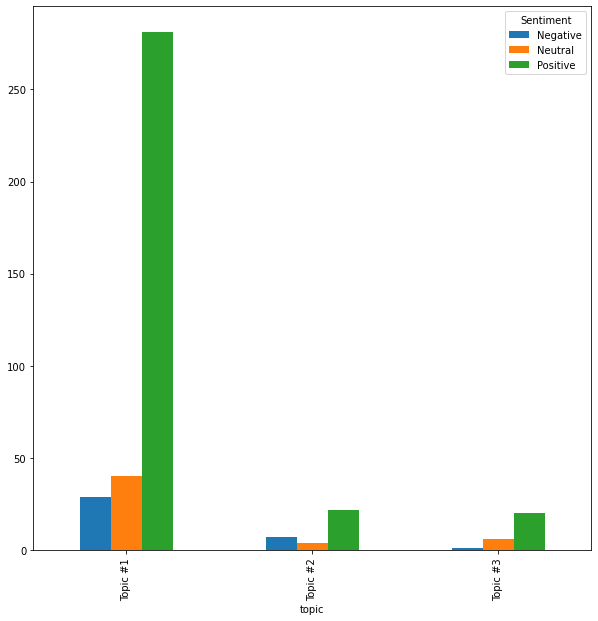

In [16]:
fig = graph_results.plot.bar(rot=90, figsize=(10,10))

# Uncomment to save the figure as a png to current directory
# fig.figure.savefig(f'{creator}_absa_gsdmm.png' , bbox_inches='tight')